## Business challenge.
Financial institutions struggle with evaluating loan applicants efficiently, leading to approval delays, high default rates and potential biases. Traditional models rely on rigid criteria, overlooking valuable insights from alternative data.

Loan Approval Predictor aims to build a predictive model that leverages historical loan data, borrower profiles  and classification techniques to refine loan approval decisions. By enhancing risk assessment and promoting fair, accessible credit opportunities, it seeks to improve financial inclusion and operational efficiency.


## Objectives
1. Enhance loan approval accuracy by leveraging historical data and predictive modeling techniques.

2. Minimize default risk by identifying high-risk applicants through classification algorithms.

3. Promote fairness in lending by analyzing biases in loan approval decisions and improving accessibility.

4. Streamline decision-making by automating loan approval predictions to reduce processing time.

5. Improve model interpretability to ensure stakeholders understand key factors influencing loan approvals.


In [40]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


### 1.Loading and Inspecting  data

In [2]:
#Load the dataset in Python using pandas and inspect the first few rows

df=pd.read_csv("loan_data.csv")
df.head(10)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
5,21.0,female,High School,12951.0,0,OWN,2500.0,VENTURE,7.14,0.19,2.0,532,No,1
6,26.0,female,Bachelor,93471.0,1,RENT,35000.0,EDUCATION,12.42,0.37,3.0,701,No,1
7,24.0,female,High School,95550.0,5,RENT,35000.0,MEDICAL,11.11,0.37,4.0,585,No,1
8,24.0,female,Associate,100684.0,3,RENT,35000.0,PERSONAL,8.90,0.35,2.0,544,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.13,3.0,640,No,1


This dataset contains loan application records, including applicant demographics, financial details, credit history and loan approval status. It aims to identify patterns in borrower profiles and factors influencing loan approvals.

In [3]:
# Checking the shape of the dataset (rows, columns)

df.shape

(45000, 14)

In [4]:
# Checking dataset structure and column details

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

 The above displays the number of non-null values, data types and memory usage, 
helping us identify missing data and potential type conversions.


In [5]:
# Convert categorical variables to category type
categorical_cols = ['person_gender', 'person_education', 'person_home_ownership', 
                   'loan_intent', 'previous_loan_defaults_on_file', 'loan_status']
for col in categorical_cols:
    df[col] = df[col].astype('category')
categorical_cols



['person_gender',
 'person_education',
 'person_home_ownership',
 'loan_intent',
 'previous_loan_defaults_on_file',
 'loan_status']

In [6]:
# Handle outliers using IQR
numeric_cols = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 
                'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 
                'credit_score']
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
numeric_cols

['person_age',
 'person_income',
 'person_emp_exp',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'credit_score']

In [7]:
# One-hot encode categorical variables (excluding loan_status as it's the target)
categorical_cols_to_encode = ['person_gender', 'person_education', 'person_home_ownership', 
                             'loan_intent', 'previous_loan_defaults_on_file']

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols_to_encode, drop_first=True)

# Ensure loan_status is numeric
df_encoded['loan_status'] = df_encoded['loan_status'].astype(int)

print(df_encoded.head())  # View the first few rows
print(df_encoded.columns)  # Check the column names




   person_age  person_income  person_emp_exp  loan_amnt  loan_int_rate  \
0        22.0        71948.0             0.0  23093.125          16.02   
1        21.0        12282.0             0.0   1000.000          11.14   
2        25.0        12438.0             3.0   5500.000          12.87   
3        23.0        79753.0             0.0  23093.125          15.23   
4        24.0        66135.0             1.0  23093.125          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  loan_status  \
0                 0.37                         3.0         561.0            1   
1                 0.08                         2.0         504.0            0   
2                 0.37                         3.0         635.0            1   
3                 0.37                         2.0         675.0            1   
4                 0.37                         4.0         586.0            1   

   person_gender_male  ...  person_education_Master  \
0            

In [8]:
# Assuming df_encoded is the DataFrame after one-hot encoding
# Separate numerical and categorical/binary columns
numerical_cols = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 
                  'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 
                  'credit_score']
binary_cols = [col for col in df_encoded.columns if col not in numerical_cols and col != 'loan_status']


In [9]:
# Summary Statistics for Numerical Columns
print("Summary Statistics for Numerical Columns:")
numerical_summary = df_encoded[numerical_cols].describe()
print(numerical_summary)


Summary Statistics for Numerical Columns:
         person_age  person_income  person_emp_exp     loan_amnt  \
count  45000.000000   45000.000000    45000.000000  45000.000000   
mean      27.444733   75677.400428        5.170311   9411.042900   
std        4.930055   38071.779506        5.137068   5832.950765   
min       20.000000    8000.000000        0.000000    500.000000   
25%       24.000000   47204.000000        1.000000   5000.000000   
50%       26.000000   67048.000000        4.000000   8000.000000   
75%       30.000000   95789.250000        8.000000  12237.250000   
max       39.000000  168667.125000       18.500000  23093.125000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   45000.000000         45000.000000                45000.000000   
mean       11.005676             0.138842                    5.783711   
std         2.976069             0.084360                    3.578787   
min         5.420000             0.000000            

In [10]:
#Summary Statistics for Binary (One-Hot Encoded) Columns
print("\nSummary Statistics for Binary Columns (Proportion of 1s):")
binary_summary = df_encoded[binary_cols].mean().sort_values(ascending=False)
print(binary_summary)


Summary Statistics for Binary Columns (Proportion of 1s):
person_gender_male                    0.552022
person_home_ownership_RENT            0.520956
previous_loan_defaults_on_file_Yes    0.507956
person_education_Bachelor             0.297756
person_education_High School          0.266044
loan_intent_EDUCATION                 0.203400
loan_intent_MEDICAL                   0.189956
loan_intent_VENTURE                   0.173756
loan_intent_PERSONAL                  0.167822
person_education_Master               0.155111
loan_intent_HOMEIMPROVEMENT           0.106289
person_home_ownership_OWN             0.065578
person_education_Doctorate            0.013800
person_home_ownership_OTHER           0.002600
dtype: float64


Key Observations
- Most applicants are male (55.2%) and renters (52.1%).
- Previous loan defaults are roughly balanced (50.8% Yes, 49.2% No).
- Education-related loans make up only 20.3% of all loans.
- Doctorate degrees (1.38%) and ‘Other’ home ownership types (0.26%) are rare.


In [11]:
#Summary Statistics for Target Variable (loan_status)
print("\nSummary Statistics for Target Variable (loan_status):")
print(df_encoded['loan_status'].value_counts(normalize=True))



Summary Statistics for Target Variable (loan_status):
0    0.777778
1    0.222222
Name: loan_status, dtype: float64


In [12]:
df_encoded.to_csv("cleaned_loan_data.csv", index=False)
print("Cleaned data saved to 'cleaned_loan_data.csv'")

Cleaned data saved to 'cleaned_loan_data.csv'


### 2. Exploratory Data Analysis(EDA)

In [13]:
# Load the cleaned dataset
df_encoded= pd.read_csv("cleaned_loan_data.csv")
df_encoded

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_gender_male,...,person_education_Master,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes
0,22.0,71948.0,0.0,23093.125,16.02,0.37,3.0,561.0,1,0,...,1,0,0,1,0,0,0,1,0,0
1,21.0,12282.0,0.0,1000.000,11.14,0.08,2.0,504.0,0,0,...,0,0,1,0,1,0,0,0,0,1
2,25.0,12438.0,3.0,5500.000,12.87,0.37,3.0,635.0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,23.0,79753.0,0.0,23093.125,15.23,0.37,2.0,675.0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,24.0,66135.0,1.0,23093.125,14.27,0.37,4.0,586.0,1,1,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,47971.0,6.0,15000.000,15.66,0.31,3.0,645.0,1,1,...,0,0,0,1,0,0,1,0,0,0
44996,37.0,65800.0,17.0,9000.000,14.07,0.14,11.0,621.0,1,0,...,0,0,0,1,0,1,0,0,0,0
44997,33.0,56942.0,7.0,2771.000,10.02,0.05,10.0,668.0,1,1,...,0,0,0,1,0,0,0,0,0,0
44998,29.0,33164.0,4.0,12000.000,13.23,0.36,6.0,604.0,1,1,...,0,0,0,1,1,0,0,0,0,0


In [14]:
# Summary statistics
print("EDA Summary Statistics:")
print(df_encoded.describe(include='all'))

EDA Summary Statistics:
         person_age  person_income  person_emp_exp     loan_amnt  \
count  45000.000000   45000.000000    45000.000000  45000.000000   
mean      27.444733   75677.400428        5.170311   9411.042900   
std        4.930055   38071.779506        5.137068   5832.950765   
min       20.000000    8000.000000        0.000000    500.000000   
25%       24.000000   47204.000000        1.000000   5000.000000   
50%       26.000000   67048.000000        4.000000   8000.000000   
75%       30.000000   95789.250000        8.000000  12237.250000   
max       39.000000  168667.125000       18.500000  23093.125000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   45000.000000         45000.000000                45000.000000   
mean       11.005676             0.138842                    5.783711   
std         2.976069             0.084360                    3.578787   
min         5.420000             0.000000                    2.000000  

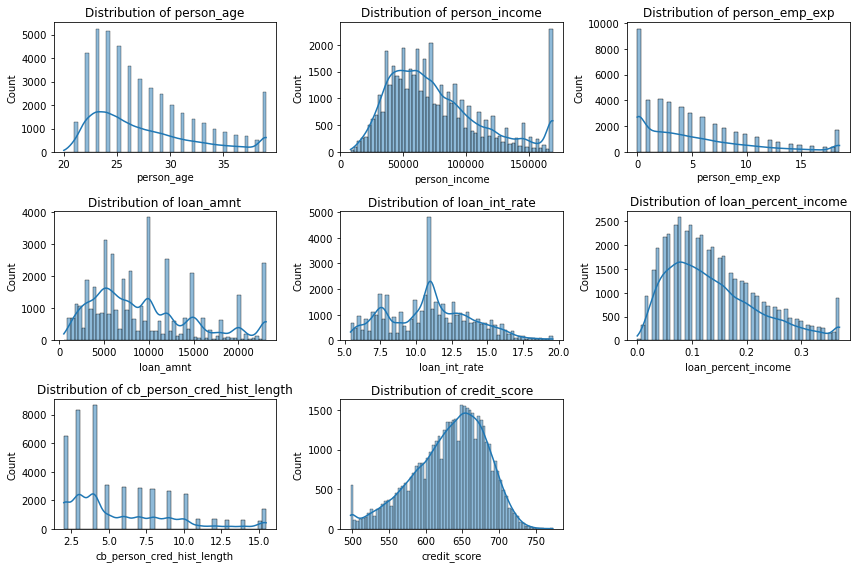

In [15]:
#Visualize Distribution of Key Numerical Columns
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_encoded[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()



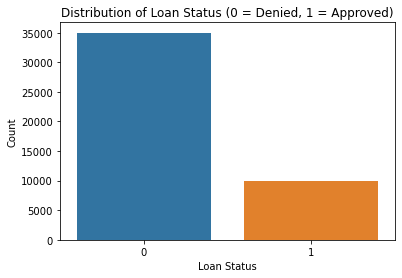

In [16]:
#Visualize Distribution of loan_status
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=df_encoded)
plt.title('Distribution of Loan Status (0 = Denied, 1 = Approved)')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()


This indicates that a substantial majority of loan applications in the dataset were rejected, highlighting a potential class imbalance that could impact predictive modeling efforts for loan approval decisions.

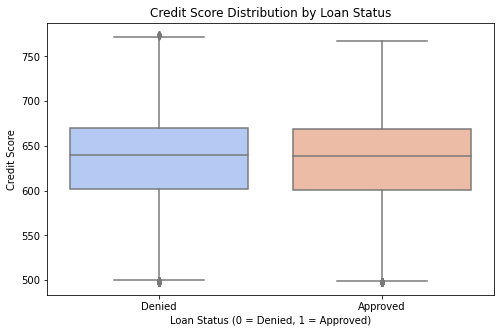

In [17]:
# Box plot of credit_score by loan_status
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_encoded, x='loan_status', y='credit_score', palette='coolwarm')
plt.title('Credit Score Distribution by Loan Status')
plt.xlabel('Loan Status (0 = Denied, 1 = Approved)')
plt.ylabel('Credit Score')
plt.xticks(ticks=[0, 1], labels=['Denied', 'Approved'])
plt.show()

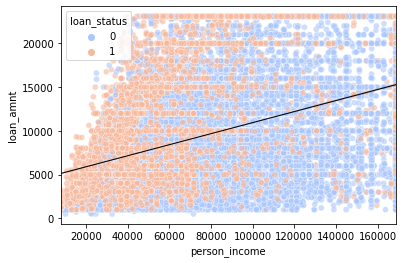

In [18]:
# Income vs Loan Amount
sns.scatterplot(data=df, x='person_income', y='loan_amnt', hue='loan_status', palette='coolwarm', alpha=0.6)
sns.regplot(data=df, x='person_income', y='loan_amnt', scatter=False, color='black', line_kws={'linewidth': 1})
correlation = df['person_income'].corr(df['loan_amnt'])

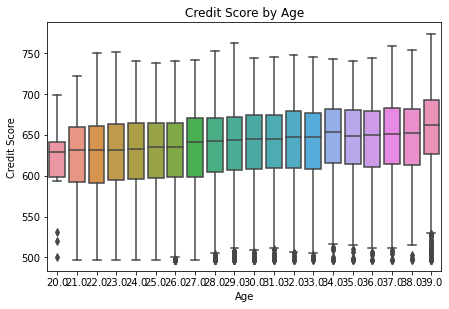

In [19]:
# Credit Score by Age (Box Plot)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.boxplot(x='person_age', y='credit_score', data=df)
plt.title('Credit Score by Age')
plt.xlabel('Age')
plt.ylabel('Credit Score')
plt.tight_layout()
plt.show()


Credit scores tend to improve and stabilize with age, with younger people showing more variation and lower scores, while older groups have higher, more consistent scores.

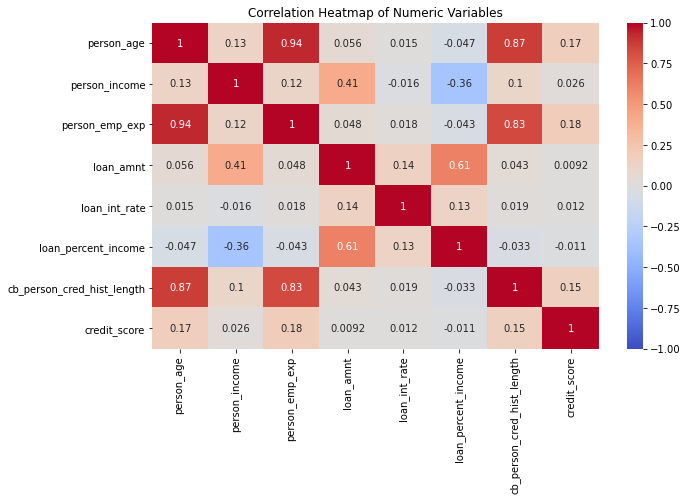

In [20]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

+ person_age and cb_person_cred_hist_length: 0.87 (strong positive correlation), meaning older people tend to have longer credit histories.
+ person_age and person_emp_exp: 0.94 (very strong positive correlation), indicating older individuals generally have more employment experience.
+ person_income and loan_amnt: 0.41 (moderate positive correlation), suggesting higher income is associated with larger loan amounts.
+ loan_amnt and loan_percent_income: 0.61 (moderate positive correlation), meaning larger loans are a bigger percentage of income.
+ person_income and loan_percent_income: -0.36 (moderate negative correlation), indicating higher income is linked to a smaller loan-to-income ratio.
+ person_age and loan_percent_income: -0.47 (moderate negative correlation), suggesting older people have a smaller loan-to-income ratio.
+ Most other pairs (e.g., credit_score with most variables) show weak correlations (close to 0), indicating little relationship.

Summary: Age strongly correlates with employment experience and credit history length. Loan amount and loan-to-income ratio are moderately related, and higher income tends to lower the loan-to-income ratio. Credit score has weak correlations with most variables.

In [21]:
# Insight
correlation = df['person_income'].corr(df['loan_amnt'])
print(f"\nInsight: There is a correlation of {correlation:.2f} between person_income and loan_amnt, suggesting higher incomes are associated with larger loans.")


Insight: There is a correlation of 0.41 between person_income and loan_amnt, suggesting higher incomes are associated with larger loans.


### 3.Modelling

In [25]:
# Define features (X) and target (y)

X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status'].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





### Train the Logistic Regression Model

In [31]:
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)



print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Train Accuracy: {train_accuracy}")



print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))





Test Accuracy: 0.7244444444444444
Train Accuracy: 0.7327777777777778
Accuracy: 0.7244444444444444
Precision: 0.43387732132808104
Recall: 0.7671641791044777
F1-Score: 0.5542774982027318


### Training a random forest model

In [ ]:

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))




Accuracy: 0.9287777777777778
Precision: 0.8931648477886273
Recall: 0.7736318407960199
F1-Score: 0.8291122367368702


##### Adjusting Decision threshold

In [30]:
y_probs = model.predict_proba(X_test)[:, 1]  
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Set a lower threshold (e.g., 0.3 instead of 0.5)
y_pred_adjusted = (y_probs >= 0.3).astype(int)

model = RandomForestClassifier(class_weight={0: 1, 1: 3}, random_state=42)
model.fit(X_train, y_train)




RandomForestClassifier(class_weight={0: 1, 1: 3}, random_state=42)

By adjusting the decision threshold we control the trade-off between recall and precision, ensuring the model prioritizes correctly identifying positive cases (reducing false negatives) or minimizing false positives based on the problem's needs.


#### Apply  Oversampling (SMOTE) to generate synthetic samples for the minority class.

In [ ]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)




In [ ]:
# Baseline Recall testing

y_pred = model.predict(X_test)
print("Baseline Recall:", recall_score(y_test, y_pred))



Baseline Recall: 0.7716417910447761


In [ ]:
#Threshold tuning Recall testing

y_probs = model.predict_proba(X_test)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Choose a lower threshold (e.g., 0.3 instead of 0.5)
optimal_threshold = 0.3
y_pred_adjusted = (y_probs >= optimal_threshold).astype(int)

print("Recall after Threshold Tuning:", recall_score(y_test, y_pred_adjusted))



Recall after Threshold Tuning: 0.891044776119403


In [ ]:
# SMOTE Recall testing

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train model on resampled data
model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_resampled, y_resampled)

# Evaluate recall on test set
y_pred_smote = model_smote.predict(X_test)
print("Recall after SMOTE:", recall_score(y_test, y_pred_smote))



Recall after SMOTE: 0.8233830845771144


The threshold tuning method appears to be more effective as it optimizes recall, reducing false negatives and ensuring the model correctly identifies approved loans more reliably than the baseline and SMOTE approach.


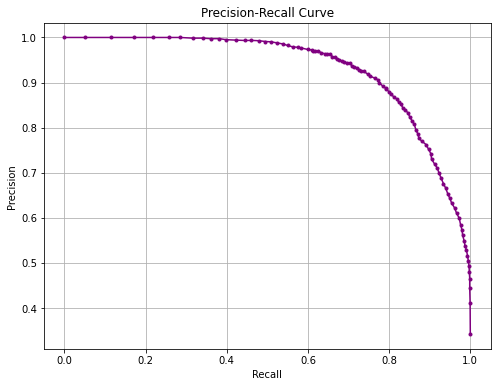

In [ ]:
# Get predicted probabilities for the positive class
y_probs = model.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()



 The Precision-Recall Curve shows the trade-off between correctly identifying approved loans and avoiding false positives. The optimal threshold is where recall is high enough to minimize false negatives while maintaining reasonable precision to ensure accurate approvals.


### Evaluating Classification Models: Logistic Regression vs. Random Forest for Loan Approvals

In my loan approval prediction project, I tested Random Forest and Logistic Regression to evaluate their classification performance. Based on model comparisons, Random Forest consistently outperformed Logistic Regression, delivering higher accuracy, precision, recall and F1-score.
Key Findings:
+ Random Forest handles non-linearity better and effectively captures complex feature interactions.

+ It provides stronger recall, reducing false negatives and ensuring more approved loans are correctly classified.

+ Logistic Regression struggled with low precision, indicating more misclassified approvals.

+ Random Forest also ranked feature importance, helping refine predictive insights.

Given these results, I am prioritizing Random Forest for further hyperparameter tuning and threshold optimization to maximize model effectiveness in predicting loan approvals.


In [ ]:
# Get feature importance scores

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='recall',
    n_iter=10,
    verbose=2,
    n_jobs=-1
)

# Fit the search
random_search.fit(X_train, y_train)


best_rf = RandomForestClassifier(**random_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)


feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("Top 10 Features by Importance:")
print(feature_importance.head(10))



Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


Top 10 Features by Importance:
                               Feature  Importance
21  previous_loan_defaults_on_file_Yes    0.479521
5                  loan_percent_income    0.145095
4                        loan_int_rate    0.134102
1                        person_income    0.087108
15          person_home_ownership_RENT    0.058912
3                            loan_amnt    0.028714
7                         credit_score    0.014248
14           person_home_ownership_OWN    0.011550
20                 loan_intent_VENTURE    0.010962
0                           person_age    0.005050


The model's feature importance ranking highlights that previous loan defaults are the most critical factor in predicting loan approval outcomes. Financial stability indicators such as loan-to-income ratio, interest rate and personal income play a substantial role, while home ownership status and loan amount provide secondary influence. This confirms that lenders prioritize past financial behavior and repayment risk when assessing loan applications.
